# What if my dataset isn't on the Hub?

You know how to use the [Hugging Face Hub](https://huggingface.co/datasets) to download datasets, but you'll often find yourself working with data that is stored either on your laptop or on a remote server. In this section we'll show you how 🤗 Datasets can be used to load datasets that aren't available on the Hugging Face Hub.

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]

## Working with local and remote datasets

🤗 Datasets provides loading scripts to handle the loading of local and remote datasets. It supports several common data formats, such as:

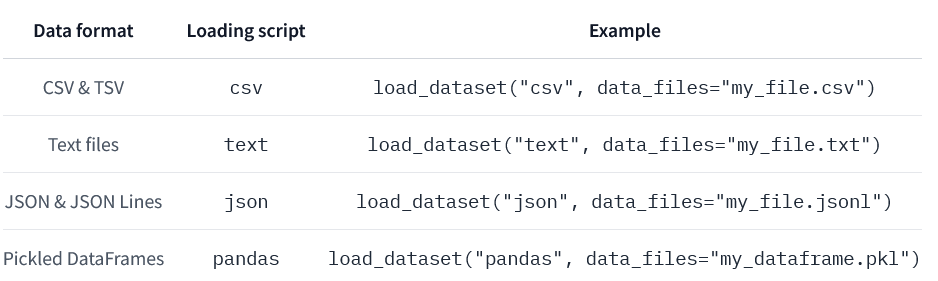

As shown in the table, for each data format we just need to specify the type of loading script in the `load_dataset()` function, along with a `data_files` argument that specifies the path to one or more files. Let's start by loading a dataset from local files; later we'll see how to do the same with remote files.

## Loading a local dataset

For this example we'll use the [SQuAD-it dataset](https://github.com/crux82/squad-it/), which is a large-scale dataset for question answering in Italian.

The training and test splits are hosted on GitHub, so we can download them with a simple wget command:

In [2]:
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

--2024-07-15 01:04:27--  https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz [following]
--2024-07-15 01:04:27--  https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7725286 (7.4M) [application/octet-stream]
Saving to: ‘SQuAD_it-train.json.gz’

SQuAD_it-train.json 100%[===================>]   7.37M  --.-KB/s    in 0.06s   

2024-07-15 01:04:28 (120 MB/s) - ‘SQuAD_it-train.json.gz’ saved [7725286/7725286]

--2024

This will download two compressed files called `SQuAD_it-train.json.gz` and `SQuAD_it-test.json.gz`, which we can decompress with the Linux gzip command:

In [3]:
!gzip -dkv SQuAD_it-*.json.gz

SQuAD_it-test.json.gz:	 87.5% -- created SQuAD_it-test.json
SQuAD_it-train.json.gz:	 82.3% -- created SQuAD_it-train.json


We can see that the compressed files have been replaced with `SQuAD_it-train.json` and `SQuAD_it-test.json`, and that the data is stored in the JSON format.

To load a JSON file with the `load_dataset()` function, we just need to know if we're dealing with ordinary JSON (similar to a nested dictionary) or JSON Lines (line-separated JSON). Like many question answering datasets, SQuAD-it uses the **nested format**, with all the text stored in a data field. This means we can load the dataset by specifying the field argument as follows:

In [4]:
from datasets import load_dataset

squad_it_dataset = load_dataset("json", data_files="SQuAD_it-train.json", field="data")

Generating train split: 0 examples [00:00, ? examples/s]

By default, loading local files creates a `DatasetDict` object with a train split. We can see this by inspecting the squad_it_dataset object:

In [5]:
squad_it_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
})

This shows us the number of rows and the column names associated with the training set. We can view one of the examples by indexing into the train split as follows:

In [6]:
squad_it_dataset["train"][0]

{'title': 'Terremoto del Sichuan del 2008',
 'paragraphs': [{'context': "Il terremoto del Sichuan del 2008 o il terremoto del Gran Sichuan, misurato a 8.0 Ms e 7.9 Mw, e si è verificato alle 02:28:01 PM China Standard Time all' epicentro (06:28:01 UTC) il 12 maggio nella provincia del Sichuan, ha ucciso 69.197 persone e lasciato 18.222 dispersi.",
   'qas': [{'answers': [{'answer_start': 29, 'text': '2008'}],
     'id': '56cdca7862d2951400fa6826',
     'question': 'In quale anno si è verificato il terremoto nel Sichuan?'},
    {'answers': [{'answer_start': 232, 'text': '69.197'}],
     'id': '56cdca7862d2951400fa6828',
     'question': 'Quante persone sono state uccise come risultato?'},
    {'answers': [{'answer_start': 29, 'text': '2008'}],
     'id': '56d4f9902ccc5a1400d833c0',
     'question': 'Quale anno ha avuto luogo il terremoto del Sichuan?'},
    {'answers': [{'answer_start': 78, 'text': '8.0 Ms e 7.9 Mw'}],
     'id': '56d4f9902ccc5a1400d833c1',
     'question': 'Che cosa ha

Great, we've loaded our first local dataset! But while this worked for the training set, what we really want is to include **both the train and test splits** in a single `DatasetDict` object so we can apply `Dataset.map()` functions across both splits at once. To do this, we can provide a dictionary to the `data_files` argument that maps each split name to a file associated with that split:

In [7]:
data_files = {"train": "SQuAD_it-train.json", "test": "SQuAD_it-test.json"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

This is exactly what we wanted. Now, we can apply various preprocessing techniques to clean up the data, tokenize the reviews, and so on.

The `data_files` argument of the `load_dataset()` function is quite flexible and can be either a single file path, a list of file paths, or a dictionary that maps split names to file paths. You can also glob files that match a specified pattern according to the rules used by the Unix shell (e.g., you can glob all the JSON files in a directory as a single split by setting `data_files="*.json"`). See the 🤗 Datasets [documentation](https://huggingface.co/docs/datasets/loading#local-and-remote-files) for more details.

The loading scripts in 🤗 Datasets actually **support automatic decompression** of the input files, so we could have skipped the use of gzip by pointing the `data_files` argument directly to the compressed files:

In [8]:
data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

This can be useful if you don't want to manually decompress many GZIP files. The automatic decompression also applies to other common formats like ZIP and TAR, so you just need to point `data_files` to the compressed files and you're good to go!

Now that you know how to load local files on your laptop or desktop, let's take a look at loading remote files.

##  Loading a remote dataset

If you're working as a data scientist or coder in a company, there's a good chance the datasets you want to analyze are stored on some remote server. Fortunately, loading remote files is just as simple as loading local ones! Instead of providing a path to local files, we point the `data_files` argument of `load_dataset()` to one or more URLs where the remote files are stored. For example, for the SQuAD-it dataset hosted on GitHub, we can just point `data_files` to the `SQuAD_it-*.json.gz` URLs as follows:

In [10]:
url = "https://github.com/crux82/squad-it/raw/master/"
data_files = {
    "train": url + "SQuAD_it-train.json.gz",
    "test": url + "SQuAD_it-test.json.gz",
}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

This returns the same `DatasetDict` object obtained above, but saves us the step of manually downloading and decompressing the `SQuAD_it-*.json.gz` files. This wraps up our foray into the various ways to load datasets that aren't hosted on the Hugging Face Hub. Now that we've got a dataset to play with, let's get our hands dirty with various data-wrangling techniques!

✏️ **Try it out!** Pick another dataset hosted on GitHub or the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) and try loading it both locally and remotely using the techniques introduced above. For bonus points, try loading a dataset that's stored in a CSV or text format (see the [documentation](https://huggingface.co/docs/datasets/loading#local-and-remote-files) for more information on these formats).

### Remote CSV file

In [12]:
# Iris flower classification dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
dataset = load_dataset('csv', data_files=url, column_names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"])
dataset

DatasetDict({
    train: Dataset({
        features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'],
        num_rows: 150
    })
})

### Remote text file

In [14]:
# Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
dataset = load_dataset('text', data_files=url)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1091
    })
})